In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Task 1

In [2]:
data_cache = {}

def load_data(file_path):
    if file_path not in data_cache:
        data_cache[file_path] = pd.read_csv(file_path)

    return data_cache[file_path]

xtest = load_data('Datasets/X_test.csv.gz')
xtrain = load_data('Datasets/X_train.csv.gz')
ytrain = load_data('Datasets/y_train.csv.gz')

In [3]:
def check_missing_data(array):
    np.isnan(array).any()

for name, data in data_cache.items():
    print(f"Observations in {name.split('/')[1]}: {data.shape[0]}")
    print(f"Variables in {name.split('/')[1]}: {data.shape[1]}")

    print(
        "Is table missing any data? " + 
        ("Yes" if check_missing_data(data) else "No")
    )

print('')
print(xtrain.head())
print(ytrain.head())

Observations in X_test.csv.gz: 670
Variables in X_test.csv.gz: 9000
Is table missing any data? No
Observations in X_train.csv.gz: 3794
Variables in X_train.csv.gz: 9000
Is table missing any data? No
Observations in y_train.csv.gz: 3794
Variables in y_train.csv.gz: 2
Is table missing any data? No

   LINC01409  LINC01128  LINC00115  FAM41C     NOC2L  HES4     ISG15  \
0   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   
1   1.296718        0.0        0.0     0.0  1.296718   0.0  0.000000   
2   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   
3   0.000000        0.0        0.0     0.0  0.000000   0.0  1.488047   
4   0.000000        0.0        0.0     0.0  0.000000   0.0  0.000000   

   C1orf159  TNFRSF18  TNFRSF4  ...    MT-ND2   MT-ATP8   MT-ATP6    MT-CO3  \
0       0.0       0.0      0.0  ...  2.560797  0.786006  3.504192  3.638454   
1       0.0       0.0      0.0  ...  3.316827  0.000000  3.832409  3.316827   
2       0.0       0.0      0.0  

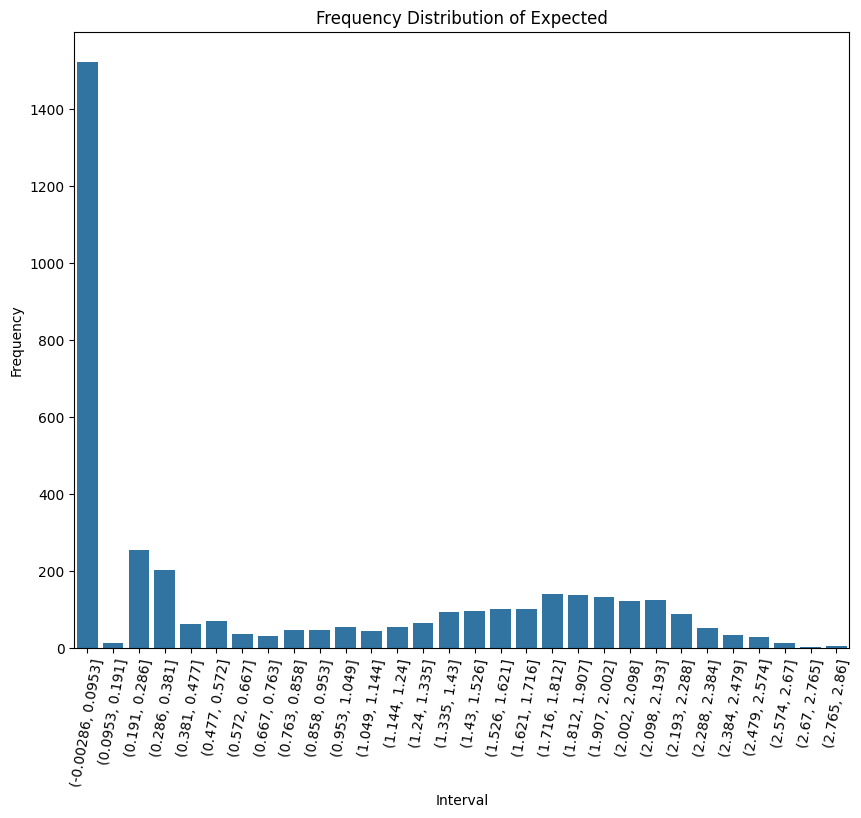

''

In [4]:
def plot_frequency_table(data, variable_name, is_qualitative):
    variable_data = data[variable_name]
    bins = 30
    plt.figure(figsize = (10, 8))

    intervals = pd.cut(variable_data, bins = bins)
    freq_table = intervals.value_counts().reset_index()
    freq_table.columns = ['Interval', 'Frequency']
    freq_table['Percentage'] = freq_table['Frequency'] 
    freq_table['Percentage'] *= 100 / len(variable_data)
    
    freq_table = freq_table.sort_values(by = 'Interval')
    
    sns.barplot(
        x = freq_table['Interval'].astype(str),
        y = freq_table['Frequency'],
    )
    plt.xlabel("Interval")
    
    plt.title(f"Frequency Distribution of {variable_name}")
    plt.ylabel("Frequency")
    # so the intervals fit on the plot
    plt.xticks(rotation = 80)
    plt.show()

    return freq_table

plot_frequency_table(ytrain, 'Expected', False)
''

In [5]:
print(ytrain['Expected'].describe())

print(f'Zero appears {np.sum(ytrain['Expected'] == 0)} times in the provided data.')

print(f'Values below 0.14: {np.sum(ytrain['Expected'] < 0.14)}')

count    3794.000000
mean        0.791096
std         0.860856
min         0.000000
25%         0.000000
50%         0.311748
75%         1.662514
max         2.860416
Name: Expected, dtype: float64
Zero appears 1523 times in the provided data.
Values below 0.14: 1523


There are really many observations that are equal to zero. Then there is a jump and there are no data points between 0 and 0.14. Then the data follows some distribution with 2 distint peaks around 0.25 and 1.8.

In [6]:
from scipy.stats import pearsonr

def add_to_best_idxs(best_idxs, idx, corr, keep_top = 100):
    if len(best_idxs) == 0:
        best_idxs = [(idx, corr)]
    else:
        for i, (_, corr_) in enumerate(best_idxs):
            if np.abs(corr) > np.abs(corr_):
                best_idxs.insert(i, (idx, corr))
                break

    if len(best_idxs) > keep_top:
        best_idxs = best_idxs[:-1]

    return best_idxs

def compare_correlations(confidence = 0.001):

    corrs = np.zeros(xtrain.shape[1])
    best_idxs = []

    for i, col in enumerate(xtrain.columns):
        column = xtrain[col]

        corr, p_value = pearsonr(column, ytrain['Expected'])
        corrs[i] = corr

        if p_value > confidence: 
            best_idxs = add_to_best_idxs(best_idxs, col, corr)

        # print(best_idxs)

    return corrs, best_idxs

corrs, best_idxs = compare_correlations()

In [7]:
def violin_corr_plot(corr_coeffs):

    sns.violinplot(data=corr_coeffs, inner="quartile")

    plt.title("Distribution of Correlation Coefficients")
    plt.xlabel("RNA vs Protein")
    plt.ylabel("Correlation Coefficient")

    # Show the plot
    plt.show()

def plot_heatmap(heatmap, title, mask_ut = True):
    if mask_ut:
        onesl = np.ones_like(heatmap)
        mask = onesl - np.triu(onesl)
        heatmap *= mask

    print(heatmap)
    min, max = np.min(heatmap), np.max(heatmap)

    plt.figure(figsize=(20, 16))  
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(
        heatmap,
        mask = mask == 0 if mask_ut else None,
        cmap = cmap,
        vmax = max,
        vmin = min, 
        center = 0,
        annot = False,  
        square = True,
        linewidths = 0.5,
        cbar_kws = {"shrink": 0.5},
        xticklabels=2,  # Show every 2nd x-axis label
        yticklabels=2,
    )

    fs = 7
    plt.xticks(fontsize = fs)  
    plt.yticks(fontsize = fs)  
    plt.title(title)
    plt.tight_layout()

    plt.show()

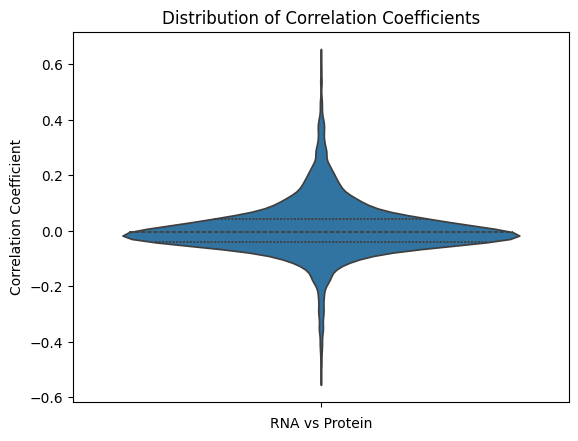

            SNX16     CASC3    KBTBD3    ARPP19     CIP2A    BCKDHA   ZDHHC24  \
SNX16    0.000000  0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
CASC3    0.025265  0.000000  0.000000 -0.000000  0.000000  0.000000 -0.000000   
KBTBD3  -0.000938  0.010074  0.000000 -0.000000  0.000000 -0.000000  0.000000   
ARPP19  -0.004544 -0.008405 -0.012323  0.000000  0.000000 -0.000000 -0.000000   
CIP2A   -0.009819  0.028268  0.047920  0.018458  0.000000 -0.000000 -0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
MIER2   -0.001562 -0.017770  0.015759 -0.022414 -0.011385 -0.021652 -0.008085   
RBM42   -0.013913  0.035540 -0.018469  0.013541  0.032906 -0.015990  0.035704   
DHX15   -0.004436  0.036959  0.000769  0.031261  0.020841  0.022647 -0.040097   
MGRN1   -0.018127 -0.003834  0.012305 -0.004844 -0.003591 -0.008933 -0.009919   
HSD17B7  0.010921  0.000467 -0.009577 -0.002425 -0.016900 -0.003856  0.014902   

           SEC16A  OLMALINC

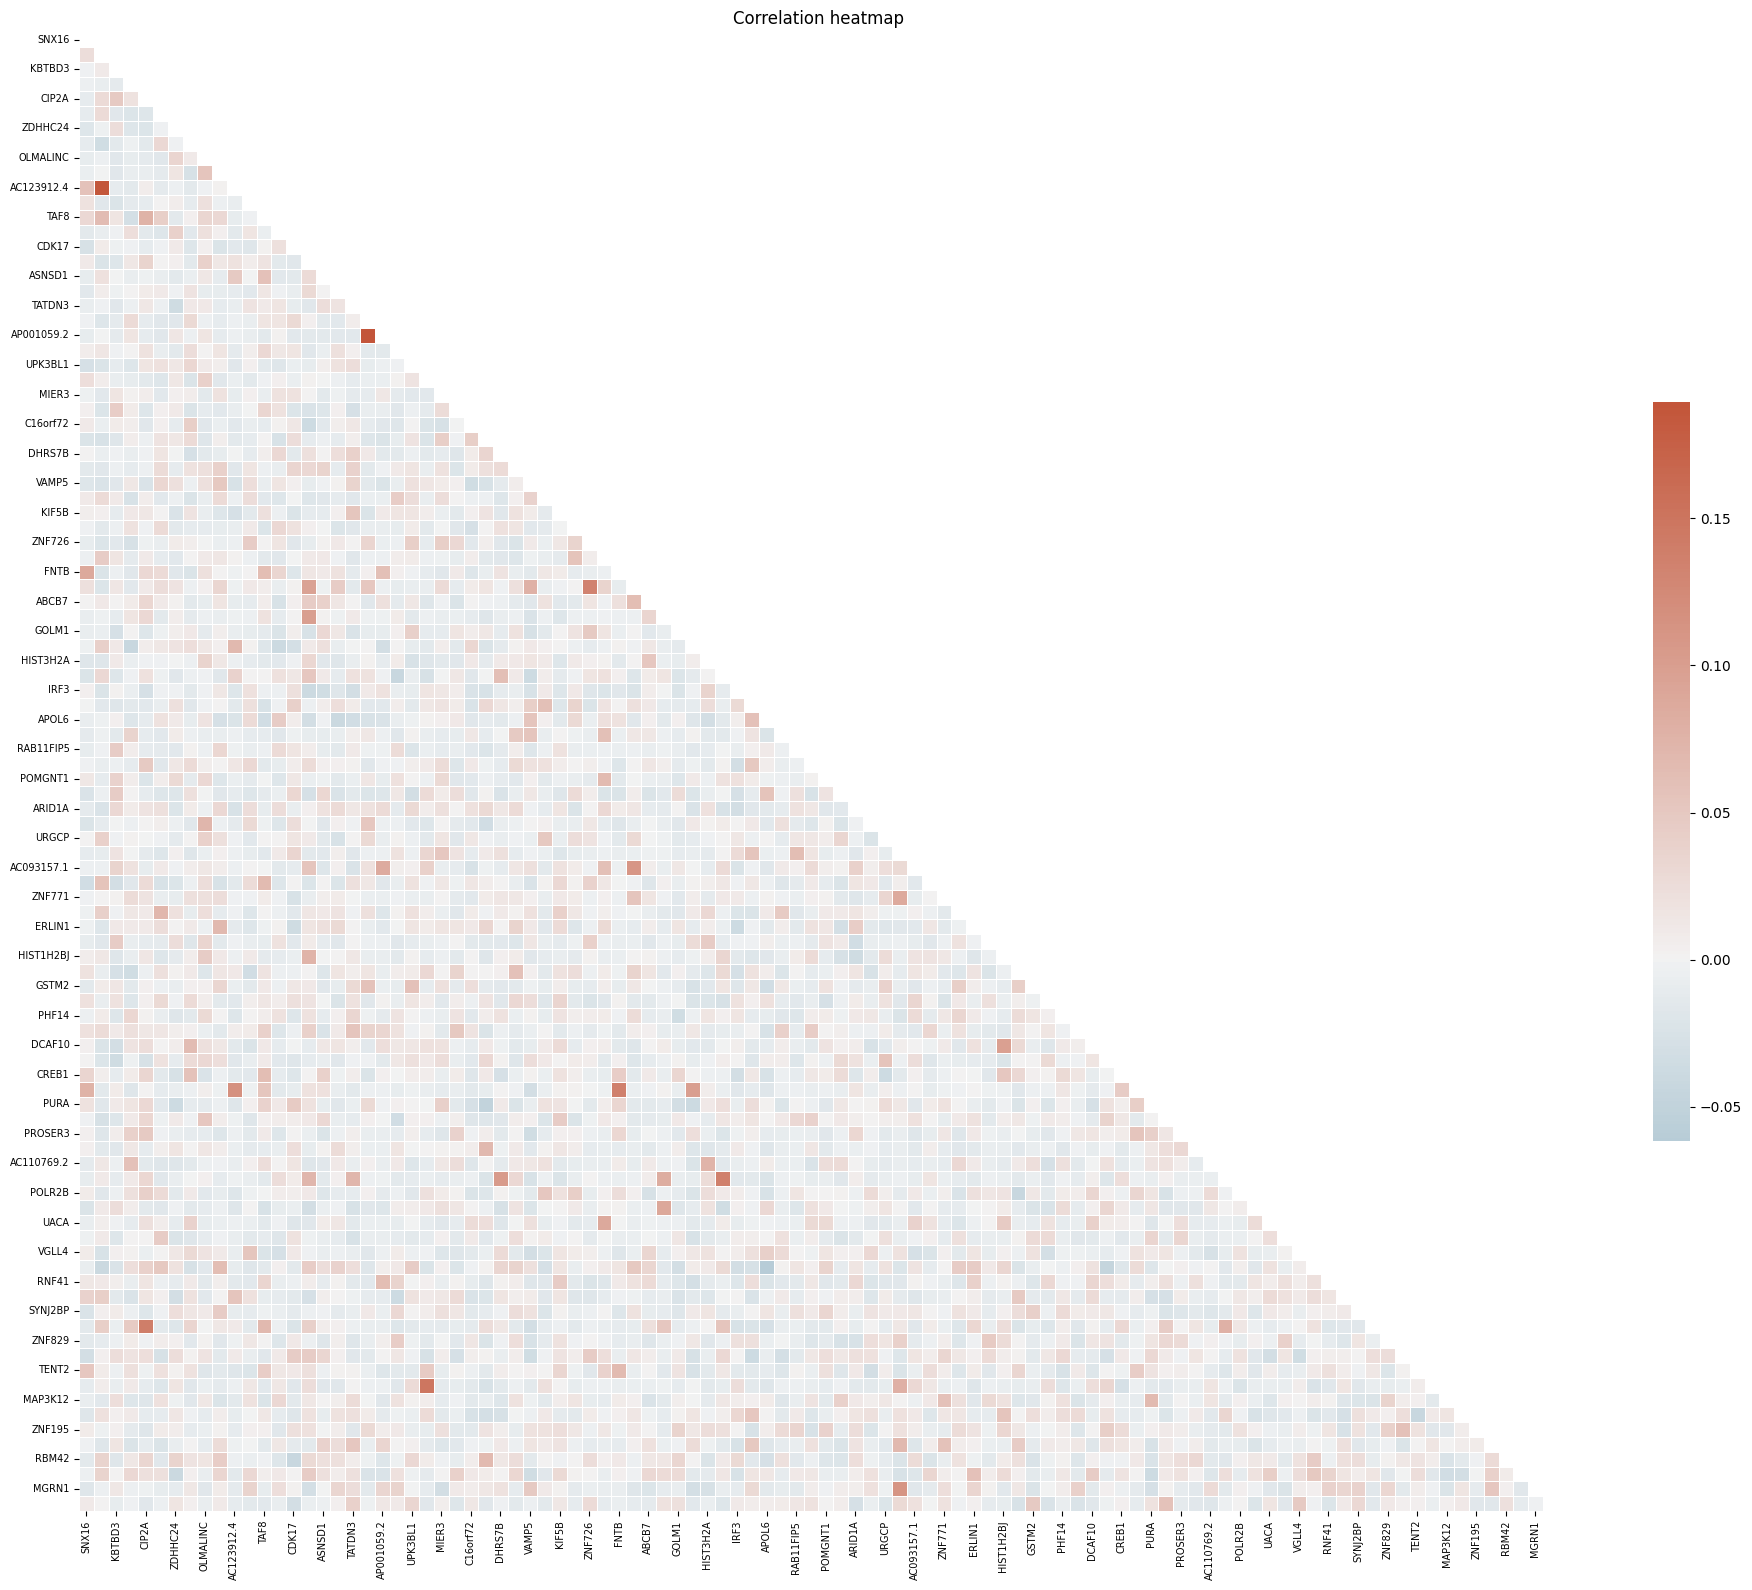

In [8]:
violin_corr_plot(corrs)

best_cols, _ = zip(*best_idxs)
heatmap = xtrain[list(best_cols)].corr()
plot_heatmap(heatmap, title = 'Correlation heatmap')

## Task 2

# ElasticNet Model

ElasticNet is a linear regression model that combines **Lasso Regression** (L1 reg) and **Ridge Regression** (L2 reg). It is effective for datasets with many predictors, especially when some predictors are either irrelevant or highly correlated. L1 regularization facilitates **variable selection** while L2 helps with **regularization** simultaneously, improving model interpretability and preventing overfitting.

---

## Optimization Function

The ElasticNet tries to minimize the following function:

<!-- $$1 / (2 * n\_samples) * ||y - Xw||^2_2 + alpha * l1\_ratio * ||w||_1 + 0.5 * alpha * (1 - l1\_ratio) * ||w||^2_2 $$ -->

$$ \frac{1}{2n} \| y - X\beta \|_2^2 + \alpha \Big[ \lambda \|\beta\|_1 + \frac{1}{2} (1 - \lambda) \|\beta\|_2^2 \Big] $$

_source: scikit-learn.org_

Where:
- y : Target variable.
- X : Input features. 
- $ \beta $ : Model coeffs. 
- $ \|...\|_1 $: L1 norm.
- $ \|...\|_2^2 $: L2 norm.
- $ \alpha $ : Regularization strength. 
- $ \lambda $: L1 ratio. 

---

## Parameters Estimated

1. **Regression coefficients  $ \beta $**
2. **Intercept $ \beta_0 $ :**
    - The constant term. 

---

## Hyperparameters

### 1. $ \alpha $ (Regularization strength):
- Controls the overall strength of regularization.

### 2. $ \lambda $ (L1 ratio):
- Determines the balance between L1 and L2 regularization
- Special case:  **$ \lambda = 1 $:** **Lasso Regression** 
    - Pure L1 regularization.
    - Performs **feature selection** by shrinking some coefficients to exactly zero.
    - Struggles with multicollinearity.
- Special case: **$ \lambda = 0 $:** **Ridge Regression** 
    - Pure L2 regularization.
    - Handles **multicollinearity** by stabilizing correlated coefficients.
    - Does not perform feature selection; all coefficients remain non-zero.

By tuning $ \alpha $ and $ \lambda $ ElasticNet adapts to the specific properties of the dataset.


In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

SEED = 45

In [10]:
from sklearn.model_selection import KFold 

def CV_divide(xs, ys, partitions = 5):
    assert len(xs) == len(ys)
    kf = KFold(
        n_splits = partitions,
        shuffle = True,
        random_state = SEED,
    )

    for train_idx, val_idx in kf.split(xs):
        xtrain, xval = xs[train_idx], xs[val_idx]
        ytrain, yval = ys[train_idx], ys[val_idx]

        yield (xtrain, ytrain), (xval, yval)

In [11]:
def run_ElasticNet(trainset, alpha, l1_ratio, random_state = SEED, partitions = 5, max_iter = None):
    train_error, test_error = 0, 0
    X, Y = trainset

    if max_iter is None:
        model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state = random_state)
    else:
        model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state = random_state, max_iter = max_iter)
    
    print(alpha, l1_ratio)

    for train, test in CV_divide(X, Y, partitions = partitions):
        xtrain, ytrain = train
        xtest, ytest = test

        model.fit(xtrain, ytrain)

        train_y_pred = model.predict(xtrain)
        y_pred = model.predict(xtest)

        train_error += mean_squared_error(ytrain, train_y_pred)
        test_error += mean_squared_error(ytest, y_pred)

    return train_error / partitions, test_error / partitions

In [12]:
GRID_SIZE = 5

def CV_run(lamb, alph, xtrain, ytrain):

    lambdas, alphas = np.meshgrid(lamb, alph)

    results = np.zeros((GRID_SIZE, GRID_SIZE))

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            results[i][j] = run_ElasticNet((xtrain, ytrain), alphas[i][j], lambdas[i][j])[1]

    print(np.max(results), np.min(results))

    return results, lambdas, alphas

xt = np.array(xtrain)
yt = np.array(ytrain)[:, 1].reshape(-1, 1)

lambda_arr = np.concat([[0], np.linspace(0.05, 0.2, GRID_SIZE - 2), [1]])
alpha_arr = np.linspace(0.1, 1, GRID_SIZE)

# for clearer output
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# res_tuple = CV_run(lambda_arr, alpha_arr, xt, yt)

Conclusions:

Model doesn't seem to converge when l1_ratio is 0, but it gets the lowest errors in that case. It may be beneficial to look for l1_ratio close to 0.

1st pass results:

MSE loss: \
[[0.12633889 0.11695261 0.12696826 0.13579096 0.20370874] \
 [0.11642005 0.13681605 0.16317229 0.18103404 0.33775193] \
 [0.11732301 0.15469409 0.18932172 0.22007956 0.44057694] \
 [0.11971264 0.17062719 0.2144733  0.25460069 0.59316338] \
 [0.12246912 0.18431365 0.23853962 0.2880758  0.73607446]]

lambdas: \
[[0.    0.05  0.125 0.2   1.   ] \
 [0.    0.05  0.125 0.2   1.   ] \
 [0.    0.05  0.125 0.2   1.   ] \
 [0.    0.05  0.125 0.2   1.   ] \
 [0.    0.05  0.125 0.2   1.   ]] 

alphas: \
[[0.1   0.1   0.1   0.1   0.1  ] \
 [0.325 0.325 0.325 0.325 0.325] \
 [0.55  0.55  0.55  0.55  0.55 ] \
 [0.775 0.775 0.775 0.775 0.775] \
 [1.    1.    1.    1.    1.   ]] 

Min MSE loss: 0.11642005435572308 for alpha = 0 and lambda = 0.325

#### Insights

- Small lambdas (L1 Ratio):
    - When lambda is close to 0 (more Ridge-like behavior), MSE tends to be smaller, particularly for smaller values of alpha (weaker regularization).
    - Best performance occurs at (alpha=0.325, lambda=0), where MSE = 0.1164.

- High lambdas (L1 Ratio):
    - As lambda increases to 1 (purely Lasso behavior), the MSE increases significantly, indicating poor performance for higher regularization strength.

- Increasing alphas:
    - Larger values of alpha (stronger regularization) generally lead to higher MSE, particularly for high lambda.

In [ ]:
BEST_A = 0.325
BEST_L = 0.005

# Re-enable warnings
warnings.resetwarnings()
train_acc, test_acc = run_ElasticNet((xt, yt), BEST_A, BEST_L, max_iter = 5000)

print(f'{train_acc=:.8f}, {test_acc=:.8f}')

NameError: name 'train_acc' is not defined

## Task 3

In [14]:
from sklearn.ensemble import RandomForestRegressor

def run_RandomForest(trainset, n_est, max_d, max_f, random_state = SEED, partitions = 5):
    train_error, test_error = 0, 0
    X, Y = trainset

    for train, test in CV_divide(X, Y, partitions = partitions):
        model = RandomForestRegressor(
            n_estimators = n_est,
            max_depth = max_d,
            max_features = max_f,
            n_jobs = -1,
            random_state = random_state,
        )

        xtrain, ytrain = train
        xtest, ytest = test

        model.fit(xtrain, ytrain.ravel())

        train_y_pred = model.predict(xtrain)
        y_pred = model.predict(xtest)

        train_error += mean_squared_error(ytrain, train_y_pred)
        test_error += mean_squared_error(ytest, y_pred)

        print(test_error)

    return train_error / partitions, test_error / partitions

In [15]:
GRID_SIZE = 2

def CV_run_RandomForest(ne, md, mf, xtrain, ytrain):

    x, y, z = len(ne), len(md), len(mf)

    print(ne, md, mf)

    ne, md, mf = np.meshgrid(ne, md, mf)

    print(ne.shape, md.shape, mf.shape)

    results = np.zeros((x, y, z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                print(
                    ne[j][i][k],
                    md[j][i][k],
                    mf[j][i][k],
                )

                results[i][j][k] = run_RandomForest(
                    (xtrain, ytrain),
                    ne[j][i][k],
                    md[j][i][k],
                    mf[j][i][k],
                )[1]

    print(np.max(results), np.min(results))

    return results, ne, md, mf

xt = np.array(xtrain)
yt = np.array(ytrain)[:, 1].reshape(-1, 1)

ne = [60, 100]
md = [None, 30]
mf = ['sqrt', None]

# res_tuple = CV_run_RandomForest(ne, md, mf, xt, yt)

MSE loss:\
[[[0.12834956 0.11554959]\
  [0.12631654 0.11440359]]\
 [[0.1260375  0.11304446]\
  [0.12462456 0.1120295 ]]]

n_estimators:\
[[[ 60  60]\
  [100 100]]\
 [[ 60  60]\
  [100 100]]]

max_depth:\
[[[None None]\
  [None None]]\
 [[30 30]\
  [30 30]]]

max_features:\
[[['sqrt' None]\
  ['sqrt' None]]\
 [['sqrt' None]\
  ['sqrt' None]]]

#### Insights:

- max_features (sqrt vs None):
    - When max_features = None, the MSE is consistently lower compared to max_features = 'sqrt', suggesting that allowing all features at each split improves performance. 

- n_estimators (60 vs 100):
    - More trees (from n_estimators = 60 to n_estimators = 100) reduce MSE for both max_features = 'sqrt' and max_features = None.

- max_depth (None vs 30):
    - Limiting the depth (max_depth = 30) generally leads to better performance, it may prevent overfitting.

- Optimal Configuration:
    - The lowest MSE occurs when n_estimators = 100, max_depth = 30, and max_features = None:
    MSE = 0.1120

In [70]:
train_acc, test_acc = run_RandomForest((xt, yt), n_est = 100, max_d = 30, max_f = None)

print(f'{train_acc=:.8f}, {test_acc=:.8f}')

0.11130400956303535
0.22693782371424598
0.33093200000321676
0.46005004502811975
0.560147477180738
train_acc=0.01807184, test_acc=0.11202950


In [16]:
def run_ReferenceModel(trainset, partitions = 5):
    train_error, test_error = 0, 0
    X, Y = trainset

    for train, test in CV_divide(X, Y, partitions = partitions):
        _, ytrain = train
        _, ytest = test

        train_y_pred = [np.mean(ytrain)] * len(ytrain)
        y_pred = [np.mean(ytest)] * len(ytest)

        train_error += mean_squared_error(ytrain, train_y_pred)
        test_error += mean_squared_error(ytest, y_pred)

        print(test_error)

    return train_error / partitions, test_error / partitions

Why did i choose 5-fold validation:

- Number of Observations:
    - There is 3,794 observations in training data.
    - Splitting the data into 5 folds means each fold will have ~759 observations for validation and ~3035 for training.
    - This should be sufficient for training models. 

- Dimensionality of Data:
    - The data has 9,000 variables, which makes it high-dimensional.
    - With 5 folds, the training set hopefully remains large enough to avoid overfitting. 

- Computational cost:
    - Training Random Forests is computationally demanding, so choosing small enough fold number is important.
    - Reduces variance in validation compared to 3 folds, while avoiding the computational cost of 10 or more folds.


### Summary

The table below compares the **MSE validation loss** for ElasticNet, Random Forest, and the reference model. Cross-validation was performed using the same 5 divisions to ensure consistency in evaluation.

| **Model**         | **Hyperparameters**                        | **MSE Validation Loss** | **Notes**                                                                                     |
|--------------------|--------------------------------------------|--------------------------|---------------------------------------------------------------------------------------------|
| **ElasticNet** | $ \alpha \in \{0.1, 0.325, 0.55, 0.775, 1.0\} $ <br> $ \lambda \in \{0, 0.05, 0.125, 0.2, 1\} $ | Best: **0.1164** | Best performance occurs for $ \alpha = 0.325 $ and $ \lambda = 0 $ (more Ridge-like behavior). |
| **Random Forest**  | $ n\_estimators \in \{60, 100\} $, <br> $ max\_depth \in \{None, 30\} $, <br> $ max\_features \in \{\text{sqrt, None}\} $ | Best: **0.1120**         | Best performance with $ n\_estimators = 100 $, $ max\_depth = 30 $, $ max\_features = None $. |
| **Reference**| None | **0.7401** | Baseline model for comparison; assigns $ \hat{y} = \bar{y} $ to all predictions. |

---

### Key Observations

1. **ElasticNet Performance**:
   - Best MSE: **0.1164**, achieved when $ \alpha = 0.325 $ and $ \lambda = 0 $.
   - ElasticNet performs better with smaller $ \lambda $ (more Ridge-like regularization).

2. **Random Forest Performance**:
   - Best MSE: **0.1120**, achieved when $ n\_estimators = 100 $, $ max\_depth = 30 $, and $ max\_features = None $.
   - Adding more trees (higher $ n\_estimators $) consistently improves performance, and restricting $ max\_depth $ to 30 may reduce overfitting.

3. **Reference Model**:
   - MSE: **0.7401**, much higher than ElasticNet or Random Forest.

---

### Best Model

The **Random Forest** model is the best based on the cross-validation results:
- **Lowest MSE**: Achieved a validation loss of **0.1120**, outperforming other models. 
- **Robustness**: Random Forest can model non-linear relationships, which may have contributed to its performance.

---

### Conclusion

Random Forest is the best-performing model in this comparison. The improvement justifies the added complexity of Random Forest over ElasticNet.


## Task 4

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

In [ ]:
def run_RandomForest_min(trainset, random_state = SEED, partitions = 5):
    train_error, test_error = 0, 0
    X, Y = trainset

    for train, test in CV_divide(X, Y, partitions = partitions):
        model = RandomForestRegressor(
            n_estimators = 500,
            max_depth = 37,
            max_features = 0.3,
            min_samples_split = 5,
            min_samples_leaf = 2,
            n_jobs = -1,
            random_state = random_state,
        )

        xtrain, ytrain = train
        xtest, ytest = test

        model.fit(xtrain, ytrain.ravel())

        train_y_pred = model.predict(xtrain)
        y_pred = model.predict(xtest)

        train_error += mean_squared_error(ytrain, train_y_pred)
        test_error += mean_squared_error(ytest, y_pred)

        print(test_error)

    return train_error / partitions, test_error / partitions

xts = np.array(xtrain_scaled)
run_RandomForest_min((xts, yt))

In [20]:
model = RandomForestRegressor(
    n_estimators = 500,
    max_depth = 37,
    max_features = 0.1,
    min_samples_split = 5,
    min_samples_leaf = 2,
    n_jobs = -1,
    random_state = SEED,
)

model.fit(xts, yt.ravel())

ytest = model.predict(np.array(xtest_scaled))

predictions = pd.DataFrame({
    "Id": np.arange(len(ytest)),
    "Expected": ytest,
})

output_filename = '431513._prediction.csv'
predictions.to_csv(output_filename, index=False, sep = ';')
print(f"Predictions saved to {output_filename}")

Predictions saved to 431513._prediction.csv
